<a href="https://colab.research.google.com/github/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/ImageSegmentationUnet/Image_segmentation_Unet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation with U-Net

In this notebook, we will be building U-Net, a type of CNN designed for quick, precise image segmentation, and using it to predict a label for every single pixel in an image - in this case, an image from a self-driving car dataset.

This type of image classification is called semantic image segmentation. It's similar to object detection as in both the cases one ask the question: "What objects are in this image and where in this image are those objects located?", but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows us to predict a precise mask for each object in the image by labelling each pixel in the image with its corresponding class. The word "semantic" here refers to what's being shown, so for example the "Car" class is indicated below by the dark blue mask, and "Person" is indicated with a red mask:

<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/ImageSegmentationUnet/images/carseg.png?raw=true" style="width:500px;height:250;">
<caption><center> <u><b>Figure 1</u></b>: Example of a segmented image <br> </center></caption>

This type of region-specific labelling is a pretty crucial consideration for self-driving cars, which requires a pixel-perfect understanding of their environment so that they can change lanes and avoid other cars, or any number of traffic obstacles that can put people's lives in danger.

## Table of Content

- [1 - Packages](#1)
- [2 - Load and Split the Data](#2)
    - [2.1 - Split Your Dataset into Unmasked and Masked Images](#2-1)
    - [2.2 - Preprocess Your Data](#2-2)
- [3 - U-Net](#3)
    - [3.1 - Model Details](#3-1)
    - [3.2 - Encoder (Downsampling Block)](#3-2)
        - [Exercise 1 - conv_block](#ex-1)
    - [3.3 - Decoder (Upsampling Block)](#3-3)
        - [Exercise 2 - upsampling_block](#ex-2)
    - [3.4 - Build the Model](#3-4)
        - [Exercise 3 - unet_model](#ex-3)
    - [3.5 - Set Model Dimensions](#3-5)
    - [3.6 - Loss Function](#3-6)
    - [3.7 - Dataset Handling](#3-7)
- [4 - Train the Model](#4)
    - [4.1 - Create Predicted Masks](#4-1)
    - [4.2 - Plot Model Accuracy](#4-2)
    - [4.3 - Show Predictions](#4-3)

## 1 - Packages

Run the cell below to import all the libraries we'll need:

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

import os
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

## 2 - Load and Split the Data

In [4]:
# !unzip data.zip

In [5]:
path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraSeg/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [6]:
len(image_list)

300

## Check out some of the unmasked and masked images from the dataset

<ipython-input-7-1c8a0edbb35a>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
<ipython-input-7-1c8a0edbb35a>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

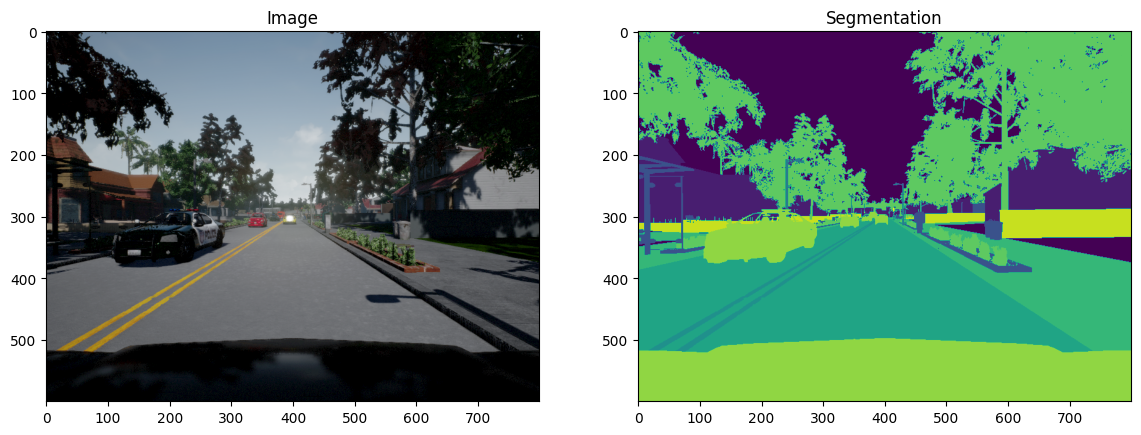

In [7]:
N = 3
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

### 2.1 - Split Dataset into Unmasked and Masked Images

In [8]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/02_00_000.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraSeg/02_00_000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/02_00_001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraSeg/02_00_001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/02_00_010.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraSeg/02_00_010.png'>)


In [9]:
image_filename = tf.constant(image_list)
masks_filename = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filename, masks_filename))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/02_02_110.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraSeg/02_02_110.png', shape=(), dtype=string)


### 2.2 - Preprocess Your Data

In [10]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

## U-Net

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segementation tasks.

U-Net builds on a previous architecture called the Fully Convoluation Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fized, as it does when the dense layers are used.

Unfornuately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough.

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways. Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back to the original input image size. It also adds skip connections, to retain information that would otherwise become loast during encoding. Skip conncections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting.

### 3.1 - Model details

<img src="https://github.com/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/ImageSegmentationUnet/images/unet.png?raw=true" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>


**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection.

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class.

The U-Net network has 23 convolutional layers in total.